#Sentiment Analysis Classification of Bitcoin Tweets Using Machine Learning Algorithms
###Dataset yang digunakan: [Bitcoin Tweets](https://www.kaggle.com/datasets/tylerdurden73/twitter-btc?select=unbalanced_twitter_btc_small.csv)

# Load a real-world dataset and prepare it for machine learning tasks.

In [14]:
import pandas as pd   # memanipulasi data
import numpy as np    # melakukan operasi matematis

# memuat dataset dengan Pandas
df = pd.read_csv('unbalanced_twitter_btc_small.csv', engine='python')

# Menghitung jumlah nilai yang hilang
print("Jumlah nilai yang hilang di setiap kolom:\n")
df.isnull().sum()

Jumlah nilai yang hilang di setiap kolom:



,0
user_followers,0
user_verified,3705
date,3705
text,3705
hard_cleaned_text,4511
soft_cleaned_text,4511
vader_sentiment,5317
afinn_sentiment,5317
sentiment,5317


In [15]:
print(f"Jumlah data sebelum pembersihan: {df.shape}")

# Menangani Missing Values
df['user_verified'] = df['user_verified'].fillna(False)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['text'] = df['text'].fillna('')
df['hard_cleaned_text'] = df['hard_cleaned_text'].fillna('')
df['soft_cleaned_text'] = df['soft_cleaned_text'].fillna('')
df['vader_sentiment'] = df['vader_sentiment'].fillna(df['vader_sentiment'].mean())
df['afinn_sentiment'] = df['afinn_sentiment'].fillna(df['afinn_sentiment'].mean())
df = df.dropna(subset=['sentiment'])

# Normalisasi dataset
df.loc[:, 'user_followers'] = pd.to_numeric(df['user_followers'], errors='coerce')

# Tampilkan jumlah baris dan kolom setelah menangani missing values
df.reset_index(drop=True, inplace=True)
print(f"Jumlah data setelah pembersihan: {df.shape}")

# Menghitung jumlah nilai yang hilang
print("Jumlah nilai yang hilang di setiap kolom:")
df.isnull().sum()

Jumlah data sebelum pembersihan: (163440, 9)
Jumlah data setelah pembersihan: (158123, 9)
Jumlah nilai yang hilang di setiap kolom:


,0
user_followers,0
user_verified,0
date,0
text,0
hard_cleaned_text,0
soft_cleaned_text,0
vader_sentiment,0
afinn_sentiment,0
sentiment,0


In [16]:
df.head()

,user_followers,user_verified,date,text,hard_cleaned_text,soft_cleaned_text,vader_sentiment,afinn_sentiment,sentiment
0,4680.0,0,2023-03-02,Which #bitcoin books should I think about read...,bitcoin books think reading next https co gas rkb,Which bitcoin books should I think about readi...,0.0000,-0.038462,-0.023077
1,770.0,0,2023-03-02,"@ThankGodForBTC I appreciate the message, but ...",appreciate message fan religious references re...,"I appreciate the message, but not a fan of the...",0.6124,0.153846,0.337268
2,576.0,0,2023-03-02,#Ethereum price update: \n\n#ETH $1664.02 USD\...,ethereum price update eth usd bitcoin btc foll...,Ethereum price update: . ETH $1664.02 USD. Bit...,0.0000,-0.038462,-0.023077
3,236.0,0,2023-03-02,CoinDashboard v3.0 is here\nAvailable on ios a...,coindashboard available ios android bitcoin ht...,CoinDashboard v3.0 is here. Available on ios a...,0.0000,-0.038462,-0.023077
4,12731.0,0,2023-03-02,#Bitcoin Short Term Fractal (4H)💥\n\nIn lower ...,bitcoin short term fractal lower timeframe btc...,Bitcoin Short Term Fractal (4H) . In lower tim...,-0.2960,-0.038462,-0.141477


#Build a classification model using Spark MLlib and evaluate its performance.

In [17]:
from pyspark.sql import SparkSession            # mengimpor SparkSession
from pyspark.sql.functions import col, when

# Inisialisasi Spark session
spark = SparkSession.builder.appName('SentimentAnalysis').getOrCreate()
sdf = spark.createDataFrame(df) # Memuat dataset

# Menambahkan kolom kategori sentimen berdasarkan kolom sentiment
sdf = sdf.withColumn(
      "sentiment_category",
      when(col("sentiment") > 0.05, "positif")
      .when(col("sentiment") < -0.05, "negatif")
      .otherwise("netral")
)

# Tampilkan hasil kategori sentimen untuk pengecekan
print("Hasil pengkategorian sentimen:")
sdf.select("soft_cleaned_text", "sentiment", "sentiment_category").show(10, False)

Hasil pengkategorian sentimen:
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+------------------+
|soft_cleaned_text                                                                                                                                                                                                                                                   |sentiment         |sentiment_category|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+------------------+
|Which bitcoin books should I think about reading next?           

**Visualisasi**

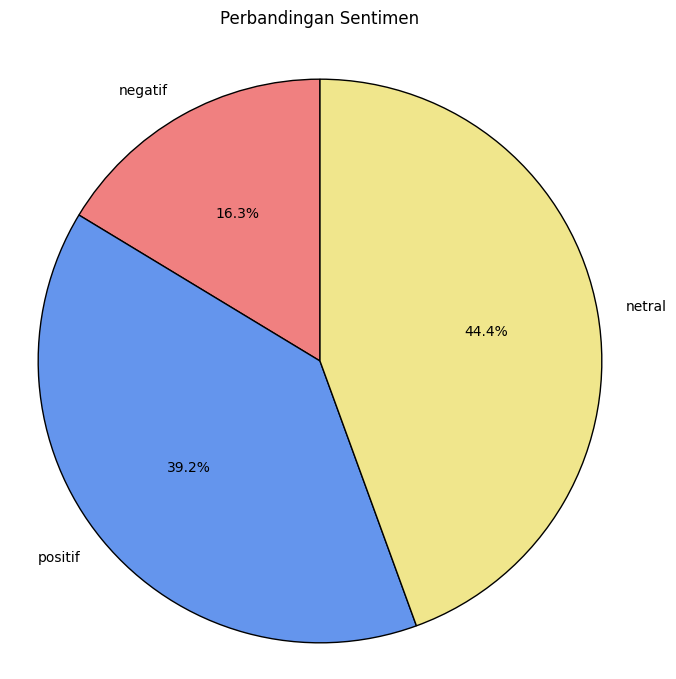

In [18]:
import matplotlib.pyplot as plt

# Menghitung jumlah sentimen kategori
sentiment_counts = sdf.groupBy('sentiment_category').count().toPandas()

# Menyiapkan data untuk pie chart
labels = sentiment_counts['sentiment_category']       # nama kategori sentimen
sizes = sentiment_counts['count']                     # jumlah data di setiap kategori
colors = ['lightcoral', 'cornflowerblue', 'khaki']    # menentukan warna

# Membuat pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'})
plt.title('Perbandingan Sentimen\n')
plt.axis('equal')
plt.show()

In [19]:
from pyspark.ml.feature import VectorAssembler # menggabungkan bebarapa kolom fitur menjadi satu kolom vektor
from pyspark.ml.classification import RandomForestClassifier # algoritma klasifikasi
from pyspark.ml.evaluation import MulticlassClassificationEvaluator # mengevaluasi model klasifikasi

# Menyusun fitur dengan kolom sentiment
assembler = VectorAssembler(inputCols=['sentiment'], outputCol='features')
sdf = assembler.transform(sdf)

# Mengubah kolom 'sentiment_category' menjadi label numerik
sdf = sdf.withColumn(
      "label",
      when(col("sentiment_category") == "positif", 0)
      .when(col("sentiment_category") == "negatif", 1)
      .otherwise(2)
)

In [20]:
# Membagi data menjadi train dan test
train_data, test_data = sdf.randomSplit([0.8, 0.2], seed=1234)
print(f"Jumlah data Train: {train_data.count()}")
print(f"Jumlah data Test: {test_data.count()}")

Jumlah data Train: 126645
Jumlah data Test: 31478


In [21]:
# Model klasifikasi dengan Random Forest
rf = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=100)

# Melatih model
rf_model = rf.fit(train_data)

# Evaluasi model
predictions = rf_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)

print(f'Akurasi Model: {accuracy}')
predictions_df = predictions.select("soft_cleaned_text", "sentiment", "label", "prediction", "probability").toPandas()
print("\nHasil Prediksi:")
predictions_df.head(10)

Akurasi Model: 0.9817650422517313

Hasil Prediksi:


,soft_cleaned_text,sentiment,label,prediction,probability
0,If I win I'm pumping Sweep! SweepArmy PitBulli...,0.303591,0,0.0,"[0.9684499054555727, 0.0, 0.03155009454442727]"
1,I am claiming my free Lightning sats from 's z...,0.204240,0,0.0,"[0.9684499054555727, 0.0, 0.03155009454442727]"
2,"Start somewhere, start small! Crypto has room ...",0.000000,2,2.0,"[0.0, 0.010361957853022548, 0.9896380421469775]"
3,Popular applause veers with the wind. Giveaway...,0.364628,0,0.0,"[0.9684499054555727, 0.0, 0.03155009454442727]"
4,Does Satoshi Nakamoto deserve a noble prize in...,0.382234,0,0.0,"[0.9684499054555727, 0.0, 0.03155009454442727]"
5,Bitcoin Double TOP. Shorting time,0.103997,0,0.0,"[0.9684499054555727, 0.0, 0.03155009454442727]"
6,$floki floki . btc . bitcoin . $bitcoin $btc....,-0.023077,2,2.0,"[0.0, 0.010361957853022548, 0.9896380421469775]"
7,Will BTC continue between this parallel channe...,0.160760,0,0.0,"[0.9684499054555727, 0.0, 0.03155009454442727]"
8,Crypto is life changing. Don't you agree? Shib...,0.144480,0,0.0,"[0.9684499054555727, 0.0, 0.03155009454442727]"
9,SeLliNG 22.500 FoLlowERS insTagRAm accoUnt. Cr...,-0.023077,2,2.0,"[0.0, 0.010361957853022548, 0.9896380421469775]"


Nilai 0.9817650422517313 pada akurasi model berarti bahwa model berhasil membuat prediksi yang benar pada **98,18%** dari data yang diuji. Untuk indeks 0, hasil prediksi di kolom **prediction** menunjukkan angka 0 sesuai dengan angka di kolom **label** yang berarti teks di indeks 0 memiliki sentimen positif. Probabilitas dari teks ini menunjukkan bahwa:
1. 0.9684499054555727: Model sangat yakin bahwa teks memiliki sentimen positif dengan probabilitas 96.8%.
2. 0.0: Model sama sekali tidak yakin bahwa teks memiliki sentimen negatif dengan probabilitas 0%.
3. 0.03155009454442727: Model sedikit yakin bahwa teks memiliki sentimen netral dengan probabilitas 3.2%.

#Explore hyperparameter tuning using cross-validation.

In [23]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# maxDepth: Mengatur kedalaman maksimum pohon keputusan pada model RandomForest.
# numTrees: Mengatur jumlah pohon dalam model RandomForest.
paramGrid = ParamGridBuilder()\
    .addGrid(rf.maxDepth, [5, 10])\
    .addGrid(rf.numTrees, [50, 100])\
    .build()

# estimator: model yang digunakan, estimatorParamMaps: grid hyperparameter, numFolds: pembagian data
crossval = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)
cv_model = crossval.fit(train_data)

# Evaluasi model dengan cross-validation
cv_predictions = cv_model.transform(test_data)
cv_accuracy = evaluator.evaluate(cv_predictions)
print(f'Akurasi dengan Cross-Validation: {cv_accuracy}')
predictions_crossval = cv_predictions.select("soft_cleaned_text", "sentiment", "label", "prediction", "probability").toPandas()
print("\nHasil Prediksi Menggunakan Cross Validation:")
predictions_crossval.head(10)

Akurasi dengan Cross-Validation: 0.9817650422517313

Hasil Prediksi Menggunakan Cross Validation:


,soft_cleaned_text,sentiment,label,prediction,probability
0,If I win I'm pumping Sweep! SweepArmy PitBulli...,0.303591,0,0.0,"[0.9682870615931773, 0.0, 0.031712938406822655]"
1,I am claiming my free Lightning sats from 's z...,0.204240,0,0.0,"[0.9682870615931773, 0.0, 0.031712938406822655]"
2,"Start somewhere, start small! Crypto has room ...",0.000000,2,2.0,"[0.0, 0.01025271156945354, 0.9897472884305465]"
3,Popular applause veers with the wind. Giveaway...,0.364628,0,0.0,"[0.9682870615931773, 0.0, 0.031712938406822655]"
4,Does Satoshi Nakamoto deserve a noble prize in...,0.382234,0,0.0,"[0.9682870615931773, 0.0, 0.031712938406822655]"
5,Bitcoin Double TOP. Shorting time,0.103997,0,0.0,"[0.9682870615931773, 0.0, 0.031712938406822655]"
6,$floki floki . btc . bitcoin . $bitcoin $btc....,-0.023077,2,2.0,"[0.0, 0.01025271156945354, 0.9897472884305465]"
7,Will BTC continue between this parallel channe...,0.160760,0,0.0,"[0.9682870615931773, 0.0, 0.031712938406822655]"
8,Crypto is life changing. Don't you agree? Shib...,0.144480,0,0.0,"[0.9682870615931773, 0.0, 0.031712938406822655]"
9,SeLliNG 22.500 FoLlowERS insTagRAm accoUnt. Cr...,-0.023077,2,2.0,"[0.0, 0.01025271156945354, 0.9897472884305465]"
